**Task 1, Question 1:** **Performance of Logistics Regression**

a) Build a regression model with no regularization, report accuracy, precision, recall, AUC

b) Use Lasso Regularization
  1) experiment with different levels of regularization, adjust strength parameter from weak to strong
  2) report best model performance
  3) What's the best value of strength parameter (alpha)? What are the variables kept?

c) Based on b), characterize high and low-probability churning customers with the logistic regression results. Is the output same as intuitions?


In [ ]:
#part a) of question 1
#Feature Engineering
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import warnings
from tabulate import tabulate
warnings.filterwarnings('ignore')

path = '/content/churn.csv'
data = pd.read_csv(path)
data = pd.get_dummies(data, columns=['gender','Partner','Dependents','PhoneService','MultipleLines',
                                     'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV',
                                     'StreamingMovies','Contract','PaperlessBilling', 'PaymentMethod'],drop_first=True)

In [ ]:
#split data and data organization
from sklearn.model_selection import train_test_split
features = data.columns[data.columns != 'Churn']
target = ['Churn']
X = data[features]
Y = (data['Churn'].astype(str).str.strip().str.lower() == 'yes').astype(int)
xtrain, xtest, ytrain, ytest = train_test_split(X,Y,test_size=0.3,random_state=23)

In [ ]:
#Preprocessing data and Z-score stdscaler
from sklearn import preprocessing
processed_xtrain = preprocessing.StandardScaler().fit(xtrain)
processed_xtrain_df = pd.DataFrame(processed_xtrain.transform(xtrain),columns=xtrain.columns)
processed_xtest = preprocessing.StandardScaler().fit(xtest)
processed_xtest_df = pd.DataFrame(processed_xtest.transform(xtest),columns=xtest.columns)

In [ ]:
#Model Training
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
log_model.fit(processed_xtrain_df,ytrain)

LogisticRegression()

In [ ]:
#Run Cross Validation, k = 10 -> find the CV probability prediction and true predictions
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

log_model_prob_predict_cv = cross_val_predict(log_model, processed_xtrain_df,ytrain.values.ravel(),cv=10, method = 'predict_proba')
log_model_predict_cv = cross_val_predict(log_model, processed_xtrain_df,ytrain.values.ravel(),cv=10)
log_model_prob_predict_1_cv = log_model_prob_predict_cv[:,1]
log_model_prob_predict_1_cv

array([0.14956727, 0.56770067, 0.2539576 , ..., 0.40984173, 0.44250743,
       0.07446378])

In [ ]:
#CV-scores of logistic regression model
log_cv_accuracy = cross_val_score(log_model,processed_xtrain_df,ytrain,scoring='accuracy',cv=10).mean()
log_cv_precision = cross_val_score(log_model,processed_xtrain_df,ytrain,scoring='precision',cv=10).mean()
log_cv_recall = cross_val_score(log_model,processed_xtrain_df,ytrain,scoring='recall',cv=10).mean()
log_cv_auc = cross_val_score(log_model,processed_xtrain_df,ytrain,scoring='roc_auc',cv=10).mean()

In [ ]:
#ROC Curve and AUC Calculation
from sklearn.metrics import roc_curve
log_fpr, log_tpr, log_thresholds = roc_curve(ytrain,log_model_prob_predict_1_cv)
print(len(pd.Series(log_thresholds).value_counts()))

1358


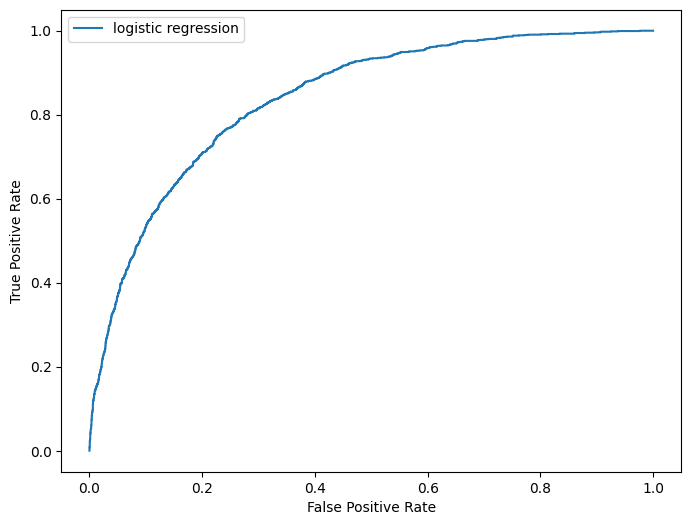

In [ ]:
# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(log_fpr,log_tpr, label="logistic regression")
plt.legend()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [ ]:
print(f'Accuracy: {log_cv_accuracy}, Precision: {log_cv_precision}, Recall: {log_cv_recall}, AUC: {log_cv_auc}')

Accuracy: 0.8043425023499727, Precision: 0.6554692845921087, Recall: 0.5288032945736434, AUC: 0.8397035422789421


In [ ]:
#Set logistic regression with LASSO regularization
log_model_l1 = LogisticRegression(penalty='l1',max_iter=1000, solver = 'liblinear')
log_model_l2 = LogisticRegression(penalty='l2',max_iter=1000)

In [ ]:
#L1-Regularization Best Model and Model Performance
l1_grid = {"C":[10**i for i in np.arange(-1,0,0.1)]}
l1_searcher = GridSearchCV(log_model_l1,l1_grid,cv=10)
l1_searcher.fit(processed_xtrain_df,ytrain.values)

print(f"Best C for logsitic regression L1: {l1_searcher.best_params_}")
print(f"Best AUC: {l1_searcher.best_score_}")


Best C for logsitic regression L1: {'C': np.float64(0.1)}
Best AUC: 0.8049514338956778


In [ ]:
#L2-Regularization Best Model and Model Performance
l2_grid = {"C":[10**i for i in np.arange(-1,0,0.1)]}
l2_searcher = GridSearchCV(log_model_l2,l2_grid,cv=10)
l2_searcher.fit(processed_xtrain_df,ytrain.values.ravel())

print(f"Best C for logsitic regression L2: {l2_searcher.best_params_}")
print(f"Best AUC: {l2_searcher.best_score_}")


Best C for logsitic regression L2: {'C': np.float64(0.7943282347242812)}
Best AUC: 0.8043425023499727


In [ ]:
#Train the optimal logistic models with optimal L1 and L2 LASSO Regressions
#Optimal C found above
OptimalLASSO1 = LogisticRegression(penalty='l1',C=l1_searcher.best_params_['C'], solver = 'liblinear')
OptimalLASSO2 = LogisticRegression(penalty='l2',C=l2_searcher.best_params_['C'])
OptimalLASSO1.fit(processed_xtrain_df,ytrain)
OptimalLASSO2.fit(processed_xtrain_df,ytrain)

LogisticRegression(C=np.float64(0.7943282347242812))

In [ ]:
#Best model performances for both L1 and L2
l1_cv_accuracy = cross_val_score(OptimalLASSO1, processed_xtrain_df, ytrain, scoring='accuracy',cv=10).mean()
l1_cv_precision = cross_val_score(OptimalLASSO1,processed_xtrain_df, ytrain, scoring='precision',cv=10).mean()
l1_cv_recall = cross_val_score(OptimalLASSO1,processed_xtrain_df, ytrain, scoring='recall',cv=10).mean()
l1_cv_auc = cross_val_score(OptimalLASSO1,processed_xtrain_df, ytrain, scoring='roc_auc',cv=10).mean()

l2_cv_accuracy = cross_val_score(OptimalLASSO2, processed_xtrain_df, ytrain, scoring='accuracy',cv=10).mean()
l2_cv_precision = cross_val_score(OptimalLASSO2,processed_xtrain_df, ytrain, scoring='precision',cv=10).mean()
l2_cv_recall = cross_val_score(OptimalLASSO2,processed_xtrain_df, ytrain, scoring='recall',cv=10).mean()
l2_cv_auc = cross_val_score(OptimalLASSO2,processed_xtrain_df, ytrain, scoring='roc_auc',cv=10).mean()

rows = [
    ["No Regularization", f"{log_cv_accuracy:.4f}", f"{log_cv_precision:.4f}", f"{log_cv_recall:.4f}", f"{log_cv_auc:.4f}"],
    ["L1", f"{l1_cv_accuracy:.4f}", f"{l1_cv_precision:.4f}", f"{l1_cv_recall:.4f}", f"{l1_cv_auc:.4f}"],
    ["L2", f"{l2_cv_accuracy:.4f}", f"{l2_cv_precision:.4f}", f"{l2_cv_recall:.4f}", f"{l2_cv_auc:.4f}"],
]

print(tabulate(rows, headers=["Model", "Accuracy", "Precision", "Recall", "AUC"]))

#L1-regularized model performs the best in 3/4 metrics among logistic regression models

Model                Accuracy    Precision    Recall     AUC
-----------------  ----------  -----------  --------  ------
No Regularization      0.8043       0.6555    0.5288  0.8397
L1                     0.805        0.6596    0.5226  0.8398
L2                     0.8043       0.6555    0.5288  0.8397


In [ ]:
#Characterize high and low-probability churning customers with the logistic regression results.
#Is the output same as intuitions?
#Take L1 (the best logistic model)

#If the beta of the feature > 0.15 then it seems like it is important
#Adjust the threshold in this cell to see what's important given thresholdss


l1_function = pd.DataFrame(OptimalLASSO1.coef_,columns=features)

l1_function = pd.DataFrame(OptimalLASSO1.coef_, columns=features)
mask = np.abs(l1_function.iloc[0]) > 0.15
l1_filtered = l1_function.loc[:, mask]
l1_filtered

,tenure,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Electronic check
0,-0.840358,0.441287,-0.279198,-0.188368,-0.260959,-0.423499,0.172032,0.190335


**Task 1, Question 2: What is the most effective decision tree you can build?**

a) Systematically experiment with different levels of model complexity using different hyperparameters in decision tree classifier

b) Report the best model performance

c) what are the values of the hyperparameters (e.g. max_depth, min_sample_split, e.t.c.), what are the variables being kept?

In [ ]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

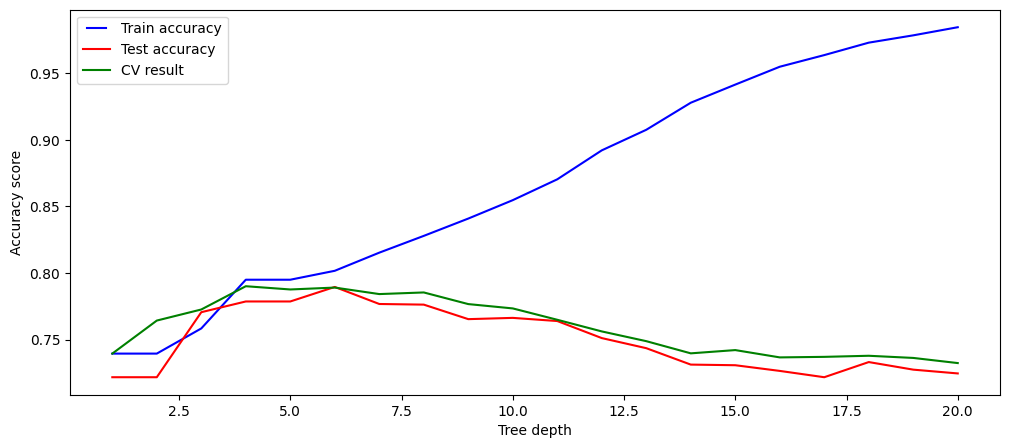

In [ ]:
#The block of code can be omitted {not graded persumably} but may be useful
#Visualize the approximate relationship between accuracy and tree depth
#Experiment with different hyperparameters
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

max_depth = np.arange(1,21,1)

train_results =[]
test_results = []
cv_results =[]

for max_depth_i in max_depth:
  dt = DecisionTreeClassifier(max_depth=max_depth_i,criterion='entropy')
  dt.fit(xtrain,ytrain)

  train_pred = dt.predict(xtrain)
  train_accuracy = accuracy_score(ytrain,train_pred,normalize=True)
  train_results.append(train_accuracy)

  test_pred = dt.predict(xtest)
  test_accuracy = accuracy_score(ytest, test_pred,normalize=True)
  test_results.append(test_accuracy)

  cv_accuracy = cross_val_score(dt,xtrain,ytrain,cv=10)
  cv_results.append(cv_accuracy.mean())

from matplotlib.legend_handler import HandlerLine2D
plt.figure(figsize=(12,5))
line1, = plt.plot(max_depth, train_results, 'b', label='Train accuracy')
line2, = plt.plot(max_depth, test_results, 'r', label='Test accuracy')
line3, = plt.plot(max_depth, cv_results, 'g', label='CV result')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Tree depth')
plt.show()

In [ ]:
#Find Hyperparameters by testing
max_depth = np.arange(1,21,1)
min_samples_split = np.arange(0,301,25)
try_grid = [{'max_depth':max_depth,
             'min_samples_split':min_samples_split}]
DTM = GridSearchCV(DecisionTreeClassifier(), param_grid=try_grid, cv=10)
DTM.fit(xtrain,ytrain)
print(f'Best hyperparameters for the models are: {DTM.best_params_}')
print(f'Best model performance: {DTM.best_score_}')


Best hyperparameters for the models are: {'max_depth': np.int64(6), 'min_samples_split': np.int64(75)}
Best model performance: 0.7939811837266445


In [ ]:
#Optimal Tree Training & Tree Visualization
from sklearn import tree
fig = plt.figure(figsize=(200,100))

OptimalTree = DecisionTreeClassifier(max_depth = DTM.best_params_['max_depth'],
                                     min_samples_split = DTM.best_params_['min_samples_split'], criterion='entropy')
OptimalTree.fit(xtrain,ytrain)

_ = tree.plot_tree(OptimalTree,feature_names=features,class_names=["Yes","No"],filled=True)

In [ ]:
#Alternative Model Performance Metrics with cross validation
dt_cv_accuracy = cross_val_score(OptimalTree,xtrain,ytrain,scoring='accuracy').mean()
dt_cv_precision = cross_val_score(OptimalTree,xtrain,ytrain,scoring='precision').mean()
dt_cv_recall = cross_val_score(OptimalTree,xtrain,ytrain,scoring='recall').mean()
dt_cv_auc = cross_val_score(OptimalTree,xtrain,ytrain,scoring='roc_auc').mean()

print(f'Using Cross Validation, the best decision tree model accuracy is {dt_cv_accuracy}, precision is {dt_cv_precision}, recall is {dt_cv_recall}, AUC is {dt_cv_auc}')

Using Cross Validation, the best decision tree model accuracy is 0.783014320498535, precision is 0.604386910805217, recall is 0.49844661964980547, AUC is 0.8192319718219524


**Task 1, Question 3: Is decision tree or logistic regression better?**

a) Carefully examine various performance metrics and comment about the differences in performance between the two methods.

b) Compare the good features identified by the decision tree and logistic regression

c) try to provide explanations about why they are different

In [ ]:
#Comparing the results
rows = [
    ["Decision Tree", f"{dt_cv_accuracy:.4f}", f"{dt_cv_precision:.4f}", f"{dt_cv_recall:.4f}", f"{dt_cv_auc:.4f}"],
    ["Logistic Regression (L1, best)", f"{l1_cv_accuracy:.4f}", f"{l1_cv_precision:.4f}", f"{l1_cv_recall:.4f}", f"{l1_cv_auc:.4f}"],
]

print(tabulate(rows, headers=["Model", "Accuracy", "Precision", "Recall", "AUC"]))
#Logistic Regression is better across all major metrics

Model                             Accuracy    Precision    Recall     AUC
------------------------------  ----------  -----------  --------  ------
Decision Tree                        0.783       0.6044    0.4984  0.8192
Logistic Regression (L1, best)       0.805       0.6596    0.5226  0.8398


In [ ]:
#Good features of L1 Logistic Regression
l1_filtered

,tenure,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Electronic check
0,-0.840358,0.441287,-0.279198,-0.188368,-0.260959,-0.423499,0.172032,0.190335


In [ ]:
#Good features of Decision Tree
dt_features_importance = pd.Series(OptimalTree.feature_importances_, index=xtrain.columns).sort_values(ascending=False)
dt_features_importance = pd.DataFrame(dt_features_importance).transpose()
dt_features_importance = dt_features_importance[dt_features_importance>=0.02]
dt_features_importance

,Contract_Two year,Contract_One year,tenure,InternetService_Fiber optic,MonthlyCharges,StreamingMovies_Yes,PaymentMethod_Electronic check,InternetService_No,PhoneService_Yes,StreamingTV_Yes,...,OnlineBackup_No internet service,OnlineBackup_Yes,StreamingTV_No internet service,TechSupport_No internet service,DeviceProtection_No internet service,DeviceProtection_Yes,StreamingMovies_No internet service,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Mailed check
0,0.309054,0.213019,0.191345,0.103249,0.079488,0.027729,0.024751,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Task 2, Question 4: Reevaluate different models with the cost information and customer's contract value**

a) Use the prediction output from the best logistic regression and decision tree model built from task 1 and compare which model gives you better overall performance with the cost information? (decision threshold = 0.5)

b) What would be the best decision threshold and minimal total cost generated from either model?

c) Whether data-driven solutions are better than "doing nothing and sending offer to everyone" which is equal to predicting everyone as not churning or predicting everyone as churning.

In [ ]:
# part a) of question 4
# Evaluate model cost with decision threshold = 0.5

def compute_cost_matrix(y_true, y_pred, CV, offer_cost=200, operation_cost=5):
    total_cost = 0
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    CV = np.array(CV)
    for i in range(len(y_true)):
        if y_pred[i] == 1 and y_true[i] == 1:
            total_cost += 0
        elif y_pred[i] == 1 and y_true[i] == 0:
            total_cost += offer_cost + operation_cost
        elif y_pred[i] == 0 and y_true[i] == 1:
            total_cost += CV[i] - offer_cost - operation_cost
        else:
            total_cost += 0
    return total_cost

# Get probability predictions from Task 1's best models
logit_probs = OptimalLASSO1.predict_proba(processed_xtest_df)[:, 1]
tree_probs = OptimalTree.predict_proba(xtest)[:, 1]

# Use threshold 0.5 to generate final predictions
logit_pred = (logit_probs >= 0.5).astype(int)
tree_pred = (tree_probs >= 0.5).astype(int)

# To get test_set with all original columns (for cost calculation)
test_indices = xtest.index
test_set = data.loc[test_indices].copy()

# Get contract values for test set
CV = test_set['MonthlyCharges'].values * 12  # annual contract value

# Calculate and print total cost for both models
cost_logit = compute_cost_matrix(ytest, logit_pred, CV)
cost_tree = compute_cost_matrix(ytest, tree_pred, CV)

print(f"Total cost using Logistic Regression (threshold=0.5): {cost_logit}")
print(f"Total cost using Decision Tree (threshold=0.5): {cost_tree}")

Total cost using Logistic Regression (threshold=0.5): 198236.79999999987
Total cost using Decision Tree (threshold=0.5): 194213.1999999999


Best threshold for Logistic Regression: 0.24, minimal cost = 147789.79999999993
Best threshold for Decision Tree: 0.19, minimal cost = 147491.99999999994


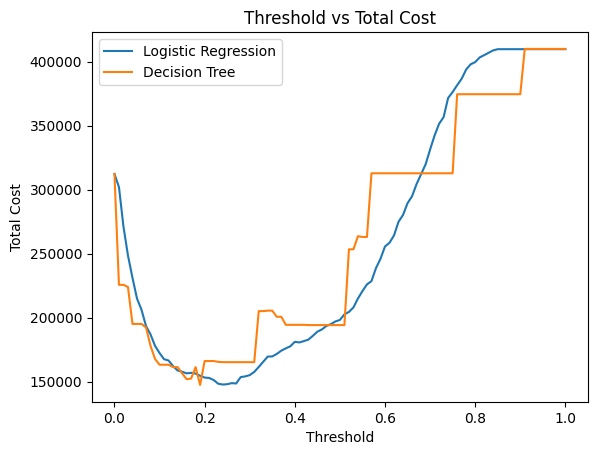

In [ ]:
# part b) of question 4
thresholds = np.arange(0, 1.01, 0.01)
costs_logit = []
costs_tree = []

for t in thresholds:
    pred_logit = (logit_probs >= t).astype(int)
    pred_tree = (tree_probs >= t).astype(int)
    costs_logit.append(compute_cost_matrix(ytest, pred_logit, CV))
    costs_tree.append(compute_cost_matrix(ytest, pred_tree, CV))

# Find optimal thresholds and minimal costs
best_thres_logit = thresholds[np.argmin(costs_logit)]
best_cost_logit = min(costs_logit)
best_thres_tree = thresholds[np.argmin(costs_tree)]
best_cost_tree = min(costs_tree)

print(f"Best threshold for Logistic Regression: {best_thres_logit:.2f}, minimal cost = {best_cost_logit}")
print(f"Best threshold for Decision Tree: {best_thres_tree:.2f}, minimal cost = {best_cost_tree}")

# Threshold vs Total Cost for each model
plt.plot(thresholds, costs_logit, label='Logistic Regression')
plt.plot(thresholds, costs_tree, label='Decision Tree')
plt.xlabel('Threshold')
plt.ylabel('Total Cost')
plt.legend()
plt.title('Threshold vs Total Cost')
plt.show()

In [ ]:
# part c) of question 4
baseline_all_no_churn = np.zeros_like(ytest)
baseline_all_churn = np.ones_like(ytest)
print("Cost (predict all no churn):", compute_cost_matrix(ytest, baseline_all_no_churn, CV))
print("Cost (predict all churn):", compute_cost_matrix(ytest, baseline_all_churn, CV))

Cost (predict all no churn): 409652.2000000005
Cost (predict all churn): 312215


**Task 2, Question 5: Making retention offer decisions based on calculating the expected return**

a) Assume we only send to customers whose expected return is positive {CV * P(churning) - 205 > 0}, using best decision tree and logistic regression models in task 1

b) Evaluate the retention offer decisions with the same cost matrix, report evaluation results.

In [ ]:
# part a) of question 5
def expected_return_offer(CV, p_churn, offer_cost=200, operation_cost=5):
    # Estimates expected benefit for each customer given churn probability
    return CV * p_churn - (offer_cost + operation_cost)

In [ ]:
# part b) of question 5
exp_return_logit = expected_return_offer(CV, logit_probs)
exp_return_tree = expected_return_offer(CV, tree_probs)
decision_logit = (exp_return_logit > 0).astype(int)
decision_tree = (exp_return_tree > 0).astype(int)

print("Cost using expected return (Logistic):", compute_cost_matrix(ytest, decision_logit, CV))
print("Cost using expected return (Tree):", compute_cost_matrix(ytest, decision_tree, CV))

Cost using expected return (Logistic): 134844.19999999995
Cost using expected return (Tree): 126766.19999999998


Question 6 is in the doc